In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scripts.forest import Forest
import scripts.timeseries as ts
from sklearn.ensemble import IsolationForest
import time

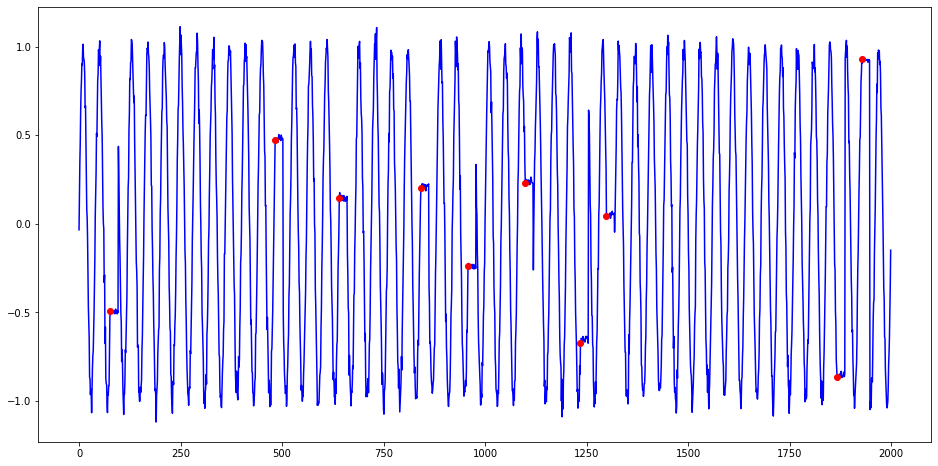

In [2]:
l_shingle = 10
l_anomaly = 20
def create_ts():
    A = ts.create_ts(2000,40,0.05)
    A, locs = ts.inject_anomalies(A, l_anomaly, 10)
    A = A + (np.random.randn(2000)/100)
    B = ts.shingle(A, l_shingle)
    return A, B, locs
#plt.figure(figsize=(20,10))
A,B, t_anoms = create_ts()
np.shape(B)
plt.figure(figsize=(16,8))
plt.plot(A, 'b')
plt.plot(t_anoms, A[t_anoms], 'ro')
plt.show()


In [3]:
kwargs = {'max_depth': 12, 'n_trees':20,  'max_samples': 200, 'max_buckets': 3, 'threshold':0, 'sample_axis': 1, 'epsilon':0.1}


In [4]:
def get_density(pts, err_rate):
    forest = Forest(**kwargs)
    start = time.time()
    forest.fit(pts)
    end  = time.time()
    print(end - start)
    print(forest.n_leaves)
    indices, _, _, _ = forest.predict(pts, err=err_rate, pct = 30)
    return indices

In [5]:
def get_iso(pts, err):
    rng = np.random.RandomState()
    dim,n_p = np.shape(pts)
    clf = IsolationForest(max_samples = 100, random_state = rng, contamination = err, n_estimators= 30, behaviour = "new")
    clf.fit(np.transpose(pts))
    Y = clf.predict(np.transpose(pts))
    iso_indices = []
    for i in range(len(Y)):
        if Y[i] == -1:
            iso_indices.append(i)
    return iso_indices

In [6]:
def find_nearest(locs, value):
    locs = np.sort(locs)
    i = 0
    while locs[i] < value:
        if i + 1 == len(locs):
            return -1,-1
        i+=1
    return locs[i],i

def compute_accuracy(loc, anomalies, l_shingle, l_anomaly):
        #print("true locations is ", loc)
        loc_set = set(loc)
        #true_positives = np.zeros(len(loc))
        true_positives = 0
        false_positives = 0
        found_set = {}
        found_set = set(found_set)
        for anom in anomalies:
            anom_set = set(range(anom - l_anomaly - l_shingle, anom + l_anomaly))
            res = anom_set.intersection(loc_set)
            if res:
                true_positives += 1
                found_set = found_set.union(res)
            else:
                false_positives += 1
        return true_positives, false_positives, found_set
                    
        

In [7]:
def compute_iso_ts(ex):
    err = 0.005
    results = np.zeros((3,12))
    for ind in range(12):
        err += 0.005
        false_positive = 0
        false_negative = 0
        for i in range(ex):
            A,B,t_anom = create_ts()
            iso_indices = get_iso(B, err)
            t_p, f_p, res = compute_accuracy(t_anom, iso_indices, l_shingle, l_anomaly)
            false_positive += f_p
            false_negative += (10 - len(res))
        results[:,ind] = [err, false_positive/ex, false_negative/ex]
    return results

In [ ]:
results_iso = compute_iso_ts(60)
plt.plot(results_iso[1,:],results_iso[2,:])
plt.show()

In [9]:
print( results_iso[0,:])

[0.01  0.015 0.02  0.025 0.03  0.035 0.04  0.045 0.05  0.055 0.06  0.065]


In [10]:
def compute_gsw_ts(ex):
    results = np.zeros((3,12))
    for i in range(ex):
        print("computing experiment", i)
        A,B, t_anom = create_ts()
        forest = Forest(**kwargs)
        forest.fit(B)
        err = 0
        for ind in range(12):
            err += 0.005
            gsw_indices, _, _, _ = forest.predict(B, err=err, pct = 30)
            t_p, false_positive, res = compute_accuracy(t_anom, gsw_indices, l_shingle, l_anomaly)
            false_negative = 10 - len(res)
            results[0,ind] += err, 
            results[1,ind] += false_positive
            results[2,ind] += false_negative
    return results/ex
        

In [11]:
results_gsw = compute_gsw_ts(10)
plt.plot(results_gsw[1,:],results_gsw[2,:])
plt.show()

computing experiment 0


ValueError: too many values to unpack (expected 4)

In [ ]:
recall_iso = (10 - results_iso[2,:])/10
recall_gsw = (10 - results_gsw[2,:])/10




In [ ]:
tp_iso = results_iso[0,:] * 2000 - results_iso[1,:]
tp_gsw = results_gsw[0,:] * 2000 - results_gsw[1,:]
precision_iso = tp_iso/(results_iso[0,:] * 2000)
precision_gsw = tp_gsw/(results_gsw[0,:] * 2000)

In [ ]:
print(tp_gsw)

In [ ]:
plt.plot(recall_iso, precision_iso,'g', label = "isolation forest", linewidth = 2, marker = "v")
plt.plot(recall_gsw, precision_gsw, 'r', label = "density forest", linewidth = 2, marker = "o")
plt.ylabel("precision")
plt.xlabel("recall")
plt.title("Time Series")
plt.legend()
plt.savefig("timeSeries.pdf", bbox_inches = 'tight')
plt.show()

In [ ]:
reca